In [1]:
from pymatgen.io.vasp import Poscar
import pandas as pd
from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
from polyhedral_analysis.octahedral_analysis import opposite_vertex_pairs
from polyhedral_analysis.utils import flatten
from collections import Counter
from tqdm import tqdm_notebook
from scipy.stats import gaussian_kde
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
recipe = PolyhedraRecipe( method='distance cutoff', 
                          coordination_cutoff=3.0, 
                          central_atoms='Ti',
                          vertex_atoms=['O','F'] )

In [3]:
# load all `bsym` generated DFT-optimised poscars

In [4]:
class Config():
    
    def __init__(self, structure, config_id, energy):
        self.structure = structure
        self.config_id = config_id
        self.energy = energy
        self.config = Configuration( structure=structure, recipes=[recipe] )
        
    def non_f4o2(self):
        count = 0
        for p in self.config.polyhedra:
            coord_count = Counter([ v.label for v in p.vertices ])
            if coord_count['F'] != 4:
                count += 1
        return count
    
    def collinear_oxygen(self):
        count = 0
        for p in self.config.polyhedra:
            vertex_pairs = opposite_vertex_pairs( p, check=False )
            for vp in vertex_pairs:
                if set( [ vp[0].label, vp[1].label ] ) == {'O'}:
                    count += 1
        return count
    
    def bond_lengths(self):
        distances = { 'O': [], 'F': [] }
        for p in self.config.polyhedra:
            for d, l in p.vertex_distances( vertex_labels=True ):
                distances[l].append( d )
        return distances

In [6]:
energies = pd.read_csv('../cluster_predictions/energies.out', delim_whitespace=True, names=['config_id', 'energy', 'dft_energy'])
energies.sort_values('config_id', inplace=True, )

In [8]:
configs = []
for i in tqdm_notebook(range(2664)):
    filename = f'../2x2x2_vasp_calculations/config_{i:04d}/POSCAR'.format(i)
    if os.path.isfile( filename ):
        structure = Poscar.from_file(filename).structure
        energy = energies.iloc[i].energy
        configs.append(Config(structure, i, energy))
print( 'Read {} POSCAR files'.format(len(configs)))


Read 65 POSCAR files


For each DFT optimised 2&times;2&times;2 TiOF2 configuration, calculate the range of Ti–F and Ti–O distances and plot this range, plus the means of both sets of distances, versus the cluster-expansion–predicted energy.

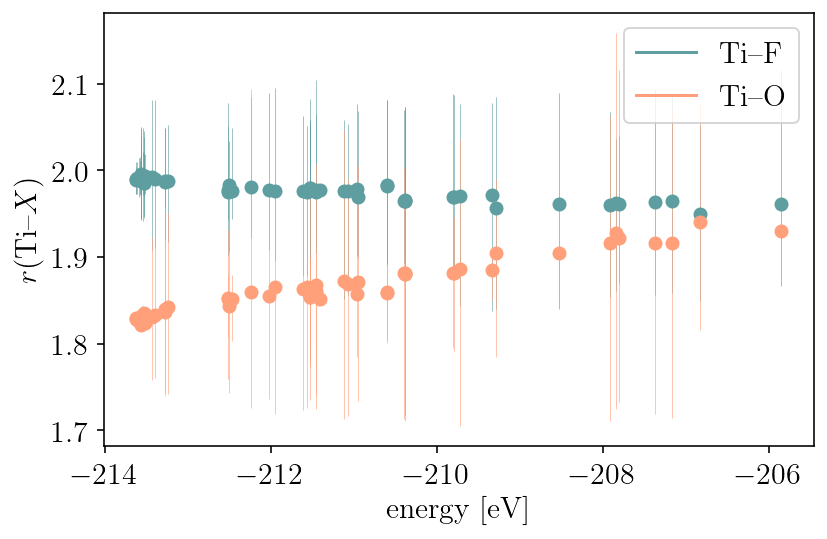

In [9]:
import matplotlib.font_manager as fm
import matplotlib
import figure_formatting

matplotlib.rc('font', family='serif') 
# matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='true') 
matplotlib.font_manager._rebuild()
matplotlib.rc('font', size=15)


f_bond_data = []
o_bond_data = []
for c in configs:
    bond_lengths = c.bond_lengths()
    mean_tif_distance = np.mean(bond_lengths['F'])
    mean_tio_distance = np.mean(bond_lengths['O'])
    tif_lower = mean_tif_distance - min(bond_lengths['F'])
    tif_upper = max(bond_lengths['F']) - mean_tif_distance
    tio_lower = mean_tio_distance - min(bond_lengths['O'])
    tio_upper = max(bond_lengths['O']) - mean_tio_distance
    plt.errorbar( c.energy, mean_tif_distance, yerr=[[tif_lower],[tif_upper]], 
                 fmt='o', c='cadetblue', ecolor='cadetblue', elinewidth=0.3 )
    plt.errorbar( c.energy, mean_tio_distance, yerr=[[tio_lower],[tio_upper]], 
                 fmt='o', c='lightsalmon', ecolor='lightsalmon', elinewidth=0.3 )
#     print( np.std(bond_lengths['F']), np.std(bond_lengths['O']) )
plt.plot( c.energy, mean_tif_distance, label=r'Ti--F', color='cadetblue')
plt.plot( c.energy, mean_tio_distance, label=r'Ti--O', color='lightsalmon')
plt.legend()
plt.xlabel('energy [eV]')
plt.ylabel(r'$r($Ti--$X)$')
plt.tight_layout()
plt.savefig('TiOF2_Ti-X_distances.pdf')
plt.show()